In [130]:
import torch
import math

def get_cosine_beta_schedule(T, s=0.008):
    """
    Cosine schedule as proposed in Nichol & Dhariwal 2021.

    Args:
        T (int): Number of diffusion steps
        s (float): Small offset to prevent singularities (default: 0.008)

    Returns:
        betas (torch.Tensor): Beta values for each timestep, shape (T,)
    """
    steps = torch.arange(T + 1, dtype=torch.float64) / T
    alpha_bars = torch.cos((steps + s) / (1 + s) * math.pi / 2) ** 2
    alpha_bars = alpha_bars / alpha_bars[0]  # normalize to 1 at t=0

    betas = 1 - (alpha_bars[1:] / alpha_bars[:-1])
    betas = torch.clamp(betas, min=1e-5, max=0.999)  # clip values for stability

    return betas.float()


In [131]:
T = 1000
betas = get_cosine_beta_schedule(T)
alphas = 1.0 - betas 

alpha_t_bars = torch.cumprod(alphas, dim=0)
sqrt_alpha_t_bars = torch.sqrt(alpha_t_bars)
sqrt_one_minus_alpha_t_bars = torch.sqrt(1-alpha_t_bars)

for i in range(10):
    
    print(betas[i], alphas[i], alpha_t_bars[i], sqrt_alpha_t_bars[i], sqrt_one_minus_alpha_t_bars[i])

tensor(4.1284e-05) tensor(1.0000) tensor(1.0000) tensor(1.0000) tensor(0.0064)
tensor(4.6142e-05) tensor(1.0000) tensor(0.9999) tensor(1.0000) tensor(0.0094)
tensor(5.0999e-05) tensor(0.9999) tensor(0.9999) tensor(0.9999) tensor(0.0118)
tensor(5.5857e-05) tensor(0.9999) tensor(0.9998) tensor(0.9999) tensor(0.0139)
tensor(6.0716e-05) tensor(0.9999) tensor(0.9997) tensor(0.9999) tensor(0.0160)
tensor(6.5574e-05) tensor(0.9999) tensor(0.9997) tensor(0.9998) tensor(0.0179)
tensor(7.0433e-05) tensor(0.9999) tensor(0.9996) tensor(0.9998) tensor(0.0198)
tensor(7.5292e-05) tensor(0.9999) tensor(0.9995) tensor(0.9998) tensor(0.0216)
tensor(8.0151e-05) tensor(0.9999) tensor(0.9995) tensor(0.9997) tensor(0.0234)
tensor(8.5011e-05) tensor(0.9999) tensor(0.9994) tensor(0.9997) tensor(0.0251)


In [132]:
print(torch.sqrt(torch.tensor(0.9999)))

tensor(0.9999)


In [133]:
def extract_value_at_timestep_t(values, timestep_t, x_shape):
    # values - 1D tensor of timestep values for whole batch
    
    batch_size = timestep_t.shape[0]
    output = values.to(timestep_t.device).gather(0,timestep_t)
    return output.reshape(batch_size,*([1]* (len(x_shape)- 1)))  # x_shape is generally (B,H,W,C), to remove B, -1 is there



In [134]:
def addNoiseKernel(x_0, timestep_t, noise=None):
    
    if noise is None:
        noise = torch.randn_like(x_0) # It will generate a batch of noises since x_shape consists B also, so will generate a noise of shape (B,H,W,C)
        
    sqrt_alpha_t_bar = extract_value_at_timestep_t(sqrt_alpha_t_bars, timestep_t, x_0.shape)
    sqrt_one_minus_alpha_t_bar = extract_value_at_timestep_t(sqrt_one_minus_alpha_t_bars, timestep_t, x_0.shape)
    
    x_t = sqrt_alpha_t_bar * x_0 + sqrt_one_minus_alpha_t_bar * noise 
    return x_t, noise 

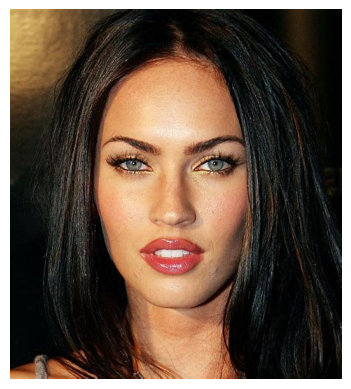

In [135]:
# Loading the image
import torchvision.transforms as T 
from PIL import Image
import matplotlib.pyplot as plt 

imagePath = "../data/LearningSet/learning1.png"
img = Image.open(imagePath).convert('RGB')

plt.imshow(img)
plt.axis('off')
plt.show()

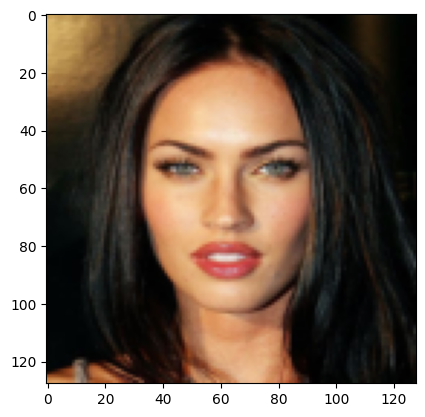

In [136]:
transform_pipeline = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

# Apply Transformation and add batch dimension, since everything will be done in batches later
# Originall Image is in B,H,W order but Matplotlib expects H,W,C order then we use .permute(1,2,0)

x_0 = transform_pipeline(img).unsqueeze(0)
plt.imshow(x_0.squeeze(0).permute(1,2,0))


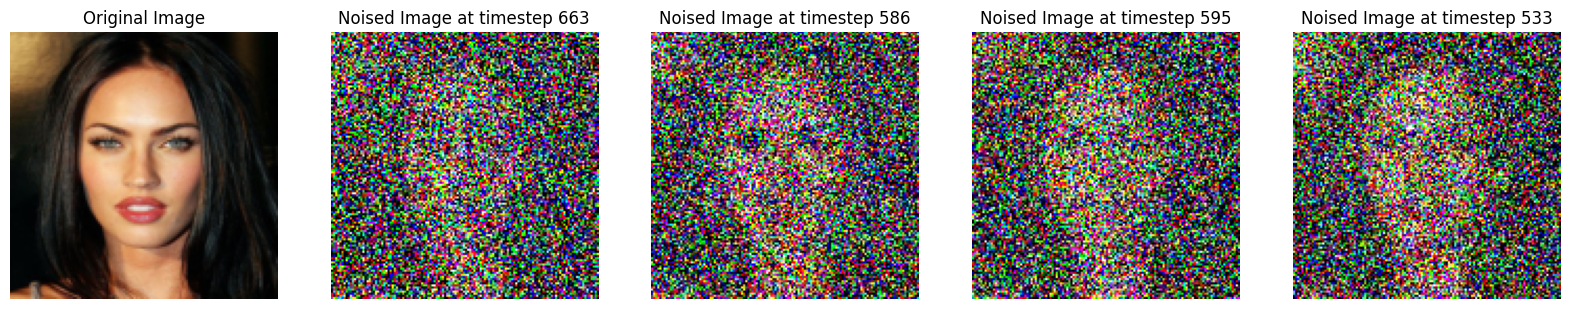

In [144]:
batch_size = x_0.shape[0]


def showImages(originalImage):
    
    figure, axes = plt.subplots(1,5, figsize=(20,5))
    axes[0].imshow(originalImage.squeeze(0).permute(1,2,0).clamp(0,1))
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    for i in range(1,5):
        
        Timesteps = 1000
        timestep_t = torch.randint(0, Timesteps, (batch_size,))
        x_t, noise = addNoiseKernel(x_0, timestep_t)
        
        axes[i].imshow(x_t.squeeze(0).permute(1,2,0).clamp(0,1))
        axes[i].set_title(f"Noised Image at timestep {timestep_t.item()}")
        axes[i].axis("off")
    
    plt.show()

showImages(x_0)